In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV

### Imorting essential library 

### importing models use for prediction  

In [2]:
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor 


import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor 

### Create function for simplicity

#### Visualization for predicted model

In [3]:
def model_plot(Y_test,Y_pred) :
    plt.figure(figsize =(24,8) )
    x_ax = range(len(Y_test))
    plt.scatter(x_ax, Y_test, label="original")
    plt.scatter(x_ax, Y_pred, label="predicted")
    plt.xlabel('Number of Date points')
    plt.ylabel('Price of Product')
    plt.title("Black Friday Sell")
    plt.legend()
    plt.show()

#### To check the symetricity

In [4]:
def checkSymm(data) :
    df_num = data.select_dtypes(include = ['int64' ,'float64'])
    fig, ax =plt.subplots(ncols=3,nrows= 1, sharex=False, figsize=(18,5))
    sns.histplot(df_num['Occupation'].value_counts(),kde = True,ax= ax[0])
    sns.histplot(df_num['Product_Category_1'].value_counts(),kde = True,ax= ax[1])
    sns.histplot(df_num['Product_Category_2'].value_counts(),kde = True,ax= ax[2])
    # sns.histplot(df_num['Purchase'].value_counts(),kde = True,ax= ax[3])
    fig.tight_layout()
    plt.show()
    # skewness along the index axis
    return print('Order of skewness   :\n',data.skew(axis = 0, skipna = True) )

#### For removal of outliers

In [5]:
def quntile(data) :   # Input type is DataFrame df[['column1','column2']]  must be numeric
    Q1 = data.quantile(0.25)#0.25
    Q3 = data.quantile(0.75)# 0.75
    IQR = Q3 - Q1
    return (data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)] )

#### For identification of missing value

In [6]:
def check_miss(data):
    return 'Missing value in Data Frame : ', data.isnull().sum()/data.shape[0]*100

#### For imputation of missing value at place of Nane 

In [7]:
def impute_miss(df_main) :
    clm = df_main.keys()
    from sklearn.impute import SimpleImputer
    for i in clm :
        df0 = pd.DataFrame(df_main[i])
        if (df0.dtypes[0] == 'float64') or (df0.dtypes[0] == 'int64'):  
            impute = SimpleImputer(missing_values=np.nan, strategy='mean')   # At place of float value importing the mean countinupus value
            df_main[i] = impute.fit_transform(df0)
        else :
            impute = SimpleImputer(missing_values=np.nan, strategy='most_frequent')   #  At place of integer value importing the mode Descrete value
            df_main[i] = impute.fit_transform(df0)
    return df_main

#### Readig the nessery file

In [8]:
train = pd.read_csv('../input/black-friday-sale/train.csv')
test = pd.read_csv('../input/black-friday-sale/test.csv')

In [9]:
print('Shape of train dataset  :  ',train.shape)
print('Shape of test  dataset   : ',test.shape)

Shape of train dataset  :   (550068, 12)
Shape of test  dataset   :  (233599, 11)


In [10]:
train.head(2)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200


In [11]:
test.head(2)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN


### checking the ,missing value

In [12]:
print(check_miss(train))
print(check_miss(test))

('Missing value in Data Frame : ', User_ID                        0.000000
Product_ID                     0.000000
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            31.566643
Product_Category_3            69.672659
Purchase                       0.000000
dtype: float64)
('Missing value in Data Frame : ', User_ID                        0.000000
Product_ID                     0.000000
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            30.969311
Product_Category_3            69.5

### Observation - 
1. Product_Category_2 have missing value --->  30.969311 %
1. Product_Category_3 have missing value --->  69.590195 %
1. there is no missing value in the object catogory

### Checkigthe type of datatype in dataset

In [13]:
print( train .info()),    print( test .info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB
None
<class 'p

(None, None)

### observation 
1.  City_Category is in alphabetical sence 
*  where A City_Category - Upper  society 
*        B City_Category - middle society
*        C City_Category - Lower  society
1.  Age catogory  - datatype is an object 
     '0-17' - younger
     '18-25','26-35' - new genration
     '36-45', '46-50', -  Mature genration
     '51-55','55+', - old age
1.  Marital stattus -  married and unmarried
1.  Gender 
*  M - male
*  F -female
1.  Occupation related to different class also may be finnetial based
1.  Product_ID - product identification code 
1.  User_id  - customers identity card
1.  Category of product  for sale  Product_Category_1 Product_Category_2 and Product_Category_3
1.  Stay_In_Current_City_Years -  how long family or people are satying in city

### Feature scaliing

### Separating the target and feature value 

In [14]:
Y = train['Purchase']                                  # Target value

In [15]:
X1 = train.drop('Purchase',axis = 1)                   # Feteture value

### Note as above we have seen that in test file lot of missing value, so for filling the missing value we concatinating all test ile in the one set of file
*  Advantage - 1] mean value will capture all esting value
*              2] mode value will observe most frequent data point in column 

In [16]:
df_main = pd.concat ([X1,test],ignore_index= False)    # Concatinating the test file 
print(df_main.shape)
df_main.head(10)

(783667, 11)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN
5,1000003,P00193542,M,26-35,15,A,3,0,1,2.0,NaN
6,1000004,P00184942,M,46-50,7,B,2,1,1,8.0,17.0
7,1000004,P00346142,M,46-50,7,B,2,1,1,15.0,NaN
8,1000004,P0097242,M,46-50,7,B,2,1,1,16.0,NaN
9,1000005,P00274942,M,26-35,20,A,1,1,8,NaN,NaN


In [17]:
df_main = df_main.drop(labels = 'Product_ID',axis= 1)       # which produxt have more demand ? we can identify

In [18]:
print(check_miss(df_main))

('Missing value in Data Frame : ', User_ID                        0.000000
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            31.388587
Product_Category_3            69.648078
dtype: float64)


* still there is missing value in produxt catogory [numeric]

In [19]:
df_main.head(2)

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000001,F,0-17,10,A,2,0,3,NaN,NaN
1,1000001,F,0-17,10,A,2,0,1,6.0,14.0


In [20]:
df_main.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
count,7.836670e+05,783667.000000,783667.000000,783667.000000,537685.000000,237858.000000
mean,1.003029e+06,8.079300,0.409777,5.366196,9.844506,12.668605
std,1.727267e+03,6.522206,0.491793,3.878160,5.089093,4.125510
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000
25%,1.001519e+06,2.000000,0.000000,1.000000,5.000000,9.000000
50%,1.003075e+06,7.000000,0.000000,5.000000,9.000000,14.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000


In [21]:
obj_clm = df_main.columns 

In [22]:
for i in obj_clm :
    print(i ,'       \n',df_main[i].unique())

User_ID        
 [1000001 1000002 1000003 ... 1004113 1005391 1001529]
Gender        
 ['F' 'M']
Age        
 ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
Occupation        
 [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
City_Category        
 ['A' 'C' 'B']
Stay_In_Current_City_Years        
 ['2' '4+' '3' '1' '0']
Marital_Status        
 [0 1]
Product_Category_1        
 [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9 20 19]
Product_Category_2        
 [nan  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.]
Product_Category_3        
 [nan 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.]


### Import Missing value

In [23]:
df_main = impute_miss(df_main)

In [24]:
print(check_miss(df_main))

('Missing value in Data Frame : ', User_ID                       0.0
Gender                        0.0
Age                           0.0
Occupation                    0.0
City_Category                 0.0
Stay_In_Current_City_Years    0.0
Marital_Status                0.0
Product_Category_1            0.0
Product_Category_2            0.0
Product_Category_3            0.0
dtype: float64)


### seperating the test and train set as previous

In [25]:
print( 'Shape of target column  : ',Y.shape)
print( 'Shape of Feature column : ',df_main.shape )

Shape of target column  :  (550068,)
Shape of Feature column :  (783667, 10)


In [26]:
feature = df_main.iloc[0:len(Y),:]           # now separting the merged test file, that was seperated above
df_train = pd.concat([feature,Y],axis = 1)
clm = df_train.keys()

In [27]:
print('Shape of the train Dataset   : ',df_train.shape)
print('Total columns in Dataset :  \n ',clm )

Shape of the train Dataset   :  (550068, 11)
Total columns in Dataset :  
  Index(['User_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')


In [28]:
df_train.head(5)

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001.0,F,0-17,10.0,A,2,0.0,3.0,9.844506,12.668605,8370
1,1000001.0,F,0-17,10.0,A,2,0.0,1.0,6.000000,14.000000,15200
2,1000001.0,F,0-17,10.0,A,2,0.0,12.0,9.844506,12.668605,1422
3,1000001.0,F,0-17,10.0,A,2,0.0,12.0,14.000000,12.668605,1057
4,1000002.0,M,55+,16.0,C,4+,0.0,8.0,9.844506,12.668605,7969


## EDA 

### Who is most frequent customer ? Gender ,Age Occupation  Marital_Status

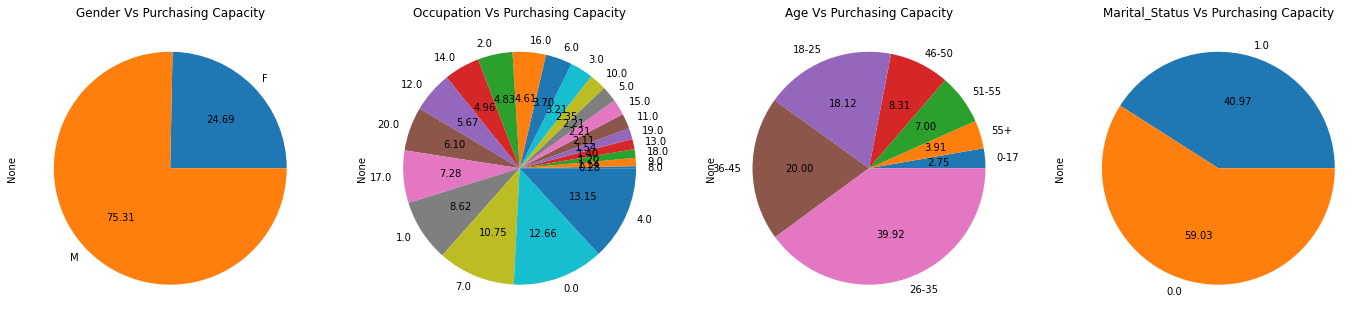

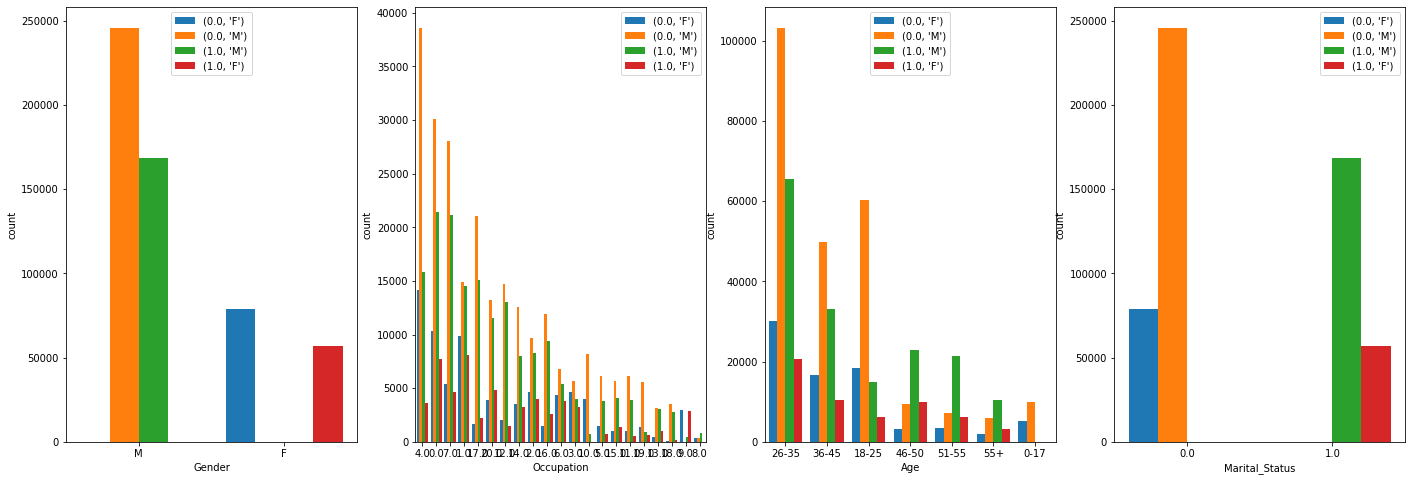

In [29]:
fig, ax =plt.subplots(ncols=4,nrows= 1, sharex=False, figsize=(24,6))
df_train.groupby('Gender').size().sort_values().plot(kind = 'pie',autopct = '%1.2f',title  ='Gender Vs Purchasing Capacity',ax= ax[0])
df_train.groupby('Occupation').size().sort_values().plot(kind = 'pie',autopct = '%1.2f',title  ='Occupation Vs Purchasing Capacity',ax= ax[1])
df_train.groupby('Age').size().sort_values().plot(kind = 'pie',autopct = '%1.2f',title  ='Age Vs Purchasing Capacity',ax= ax[2])
df_train.groupby('Marital_Status').size().sort_values().plot(kind = 'pie',autopct = '%1.2f',title  ='Marital_Status Vs Purchasing Capacity',ax= ax[3])
plt.show()

fig, ax =plt.subplots(ncols=4,nrows= 1, sharex=False, figsize=(24,8))
Hue=df_train[['Marital_Status', 'Gender']].apply(tuple, axis=1)
sns.countplot(x = 'Gender',        hue =Hue,data = df_train,order = df_train['Gender'].value_counts().index,saturation=1,ax = ax[0])
sns.countplot(x = 'Occupation',    hue =Hue,data = df_train,order = df_train['Occupation'].value_counts().index,saturation=1,ax = ax[1])
sns.countplot(x = 'Age',           hue =Hue,data = df_train,order = df_train['Age'].value_counts().index  ,saturation=1,ax = ax[2])
sns.countplot(x = 'Marital_Status',hue =Hue,data = df_train,order = df_train['Marital_Status'].value_counts().index,saturation=1,ax = ax[3])

plt.show()

1. Unmarried  Male purchasing capacity is higher than the Female puchasing capcity
1. Unmarried who have [4.0 ,0.0,7.0,1.0,17.0,20.0,12.0 ] Occupation more than 3000 item purchasing capcity On Black Friday Offer
1. Unmarried [26-35 ,  36-45, 18-25,45-50 ,51-55 ,55+ ] Age group have more than 2000 item purchasing capcity On Black Friday Offer
1. Unmaried Men are puchsing more item than the married person





    ==============================================Purchasing Capacity===============================================




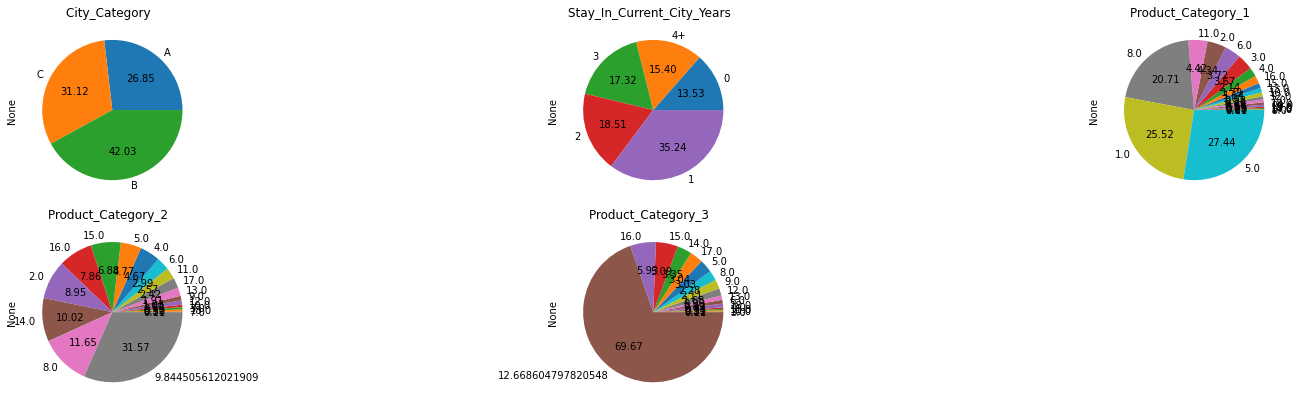

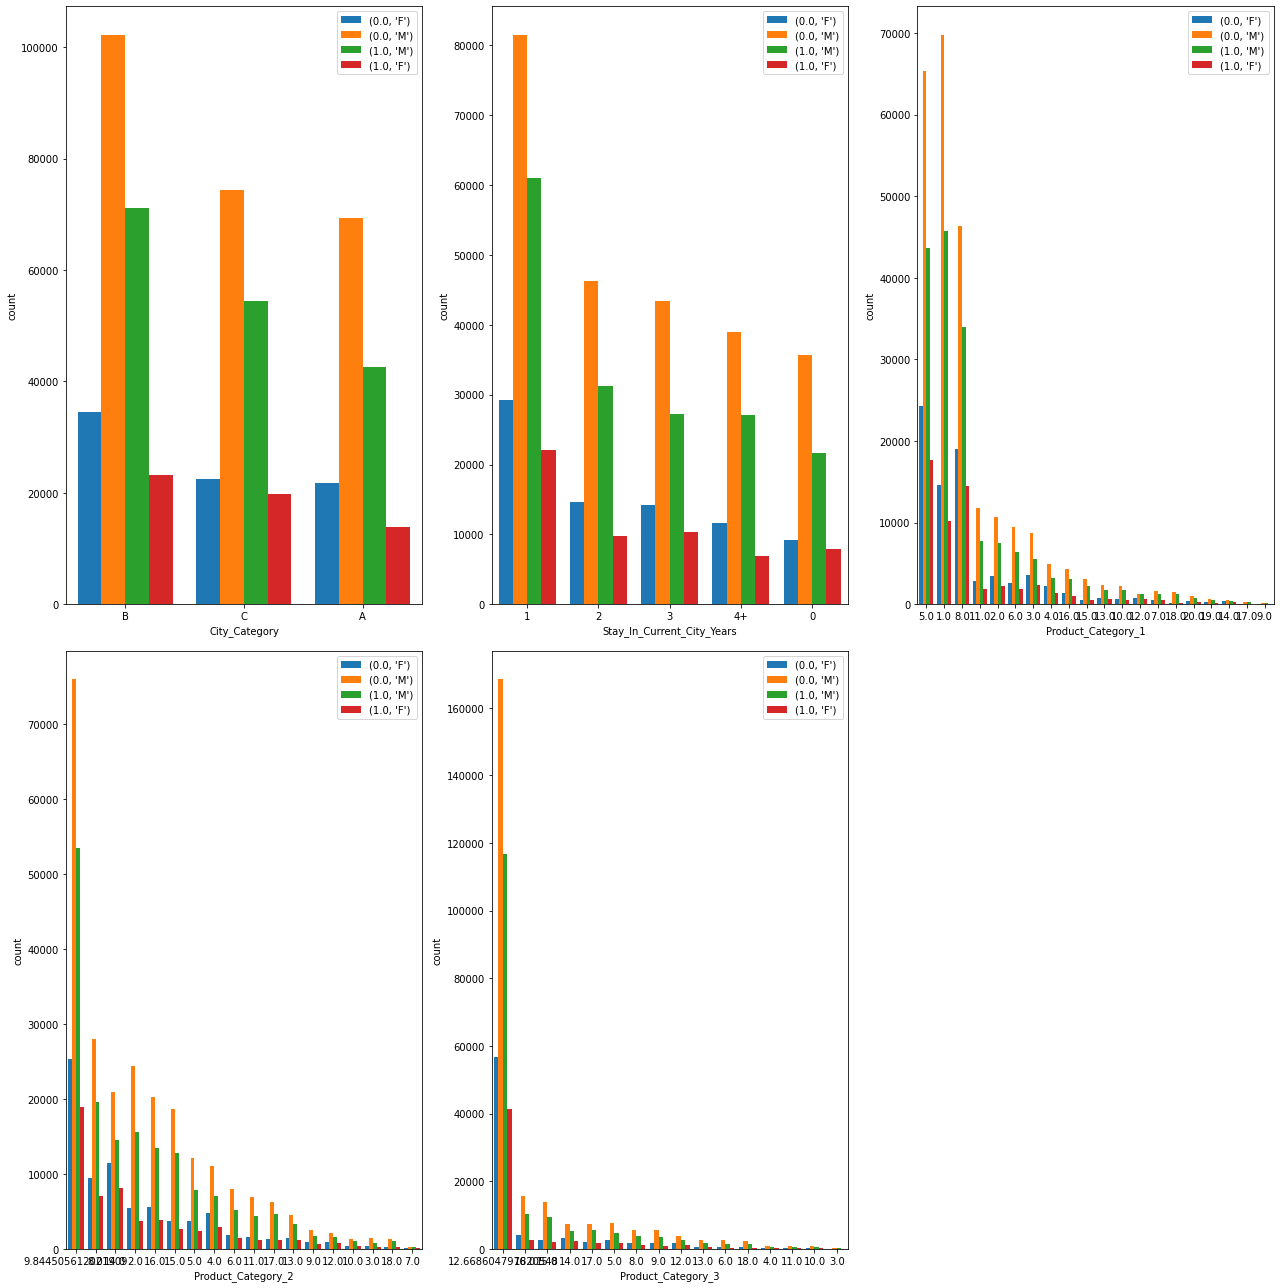

In [30]:
print('\n\n\n')
print('    ==============================================Purchasing Capacity===============================================\n\n')
fig, ax =plt.subplots(ncols=3,nrows= 2, sharex=False, figsize=(24,6))
df_train.groupby('City_Category').size().sort_values().plot(kind = 'pie',autopct = '%1.2f',title  ='City_Category  ',ax= ax[0, 0],radius=1,)
df_train.groupby('Stay_In_Current_City_Years').size().sort_values().plot(kind = 'pie',autopct = '%1.2f',title  ='Stay_In_Current_City_Years  ',ax= ax[0, 1],radius=1,)
df_train.groupby('Product_Category_1').size().sort_values().plot(kind = 'pie',autopct = '%1.2f',title  ='Product_Category_1  ',ax= ax[0, 2],radius=1,)
df_train.groupby('Product_Category_2').size().sort_values().plot(kind = 'pie',autopct = '%1.2f',title  ='Product_Category_2  ',ax= ax[1, 0],radius=1,)
df_train.groupby('Product_Category_3').size().sort_values().plot(kind = 'pie',autopct = '%1.2f',title  ='Product_Category_3  ',ax= ax[1, 1],radius=1,)
fig.tight_layout()
fig.delaxes(ax[1][2])
plt.show()

fig, ax =plt.subplots(ncols=3,nrows= 2, sharex=False, figsize=(18,18))
Hue=df_train[['Marital_Status', 'Gender']].apply(tuple, axis=1)
sns.countplot(x = 'City_Category',hue =Hue,data = df_train,order = df_train['City_Category'].value_counts().index,saturation=1,ax = ax[0, 0])
sns.countplot(x = 'Stay_In_Current_City_Years',hue =Hue,data = df_train,order = df_train['Stay_In_Current_City_Years'].value_counts().index,saturation=1,ax = ax[0, 1])
sns.countplot(x = 'Product_Category_1',hue =Hue,data = df_train,order = df_train['Product_Category_1'].value_counts().index,saturation=1,ax = ax[0, 2])
sns.countplot(x = 'Product_Category_2',hue =Hue,data = df_train,order = df_train['Product_Category_2'].value_counts().index,saturation=1,ax = ax[1, 0])
sns.countplot(x = 'Product_Category_3',hue =Hue,data = df_train,order = df_train['Product_Category_3'].value_counts().index,saturation=1,ax = ax[1, 1])
fig.tight_layout()
fig.delaxes(ax[1][2])
plt.show()

### Observation -
1. In City Category column B [42.03]%  city Unmarried Male have more puchasing capacity as compare to the C and A City 
1. In City Category column B [42.03]%  city Married Male have more puchasing capacity as compare to the C and A City 
1. In City Category column B [42.03]%  city Unmarried Female have less puchasing capacity as compare to the C and A City 
1. In City Category column B [42.03]%  city Married Female have least puchasing capacity as compare to the C and A City 
1. Unmarried Male , who is staying for one year have more purchasung capcity than 2,3 4+ year   
1. Married Male ,   who is staying for one year have more purchasung capcity than 2,3 4+ year   
1. Unmarried Female , who is staying for one year have more purchasung capcity than 2,3 4+ year 
1. Married Female , who is staying for one year have more purchasung capcity than 2,3 4+ year   
1. In Product_catogory_1 [1 ,5,8,11] have more puchasing capcity of unmarried male and then married male , as Compare to the Other & 9.0 and 7.0 have least puchasing capacity
1. In Product_catogory_2 [9.84, 5.6] have more puchasing capcity of  unmarried male and then married male ,as Compare to  the Other & [7.0, 18.0 ,3.0] have least puchasing capacity
1. In Product_catogory_3 [12.67, 16.15,14] have more puchasing capcity of unmarried male and then married male ,as Compare to  the Other & [7.0, 18.0 ,3.0] have least puchasing capacity
1. 

### Who makes MORE payment ?

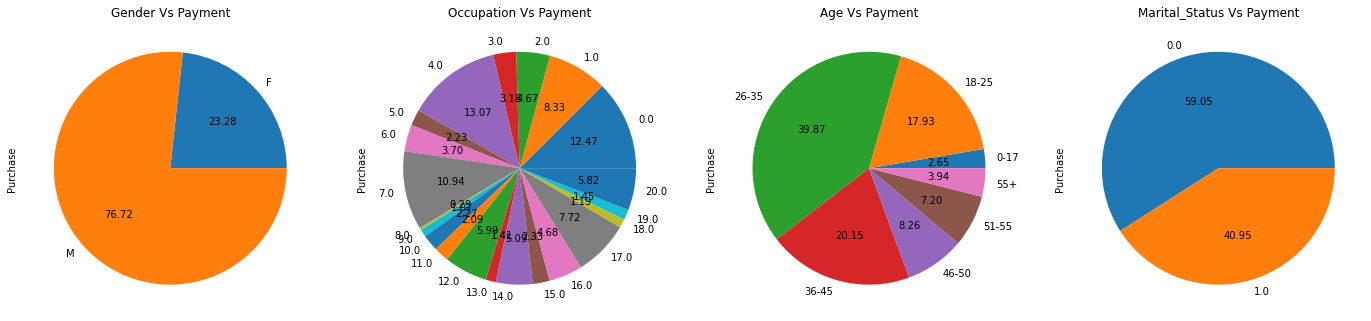

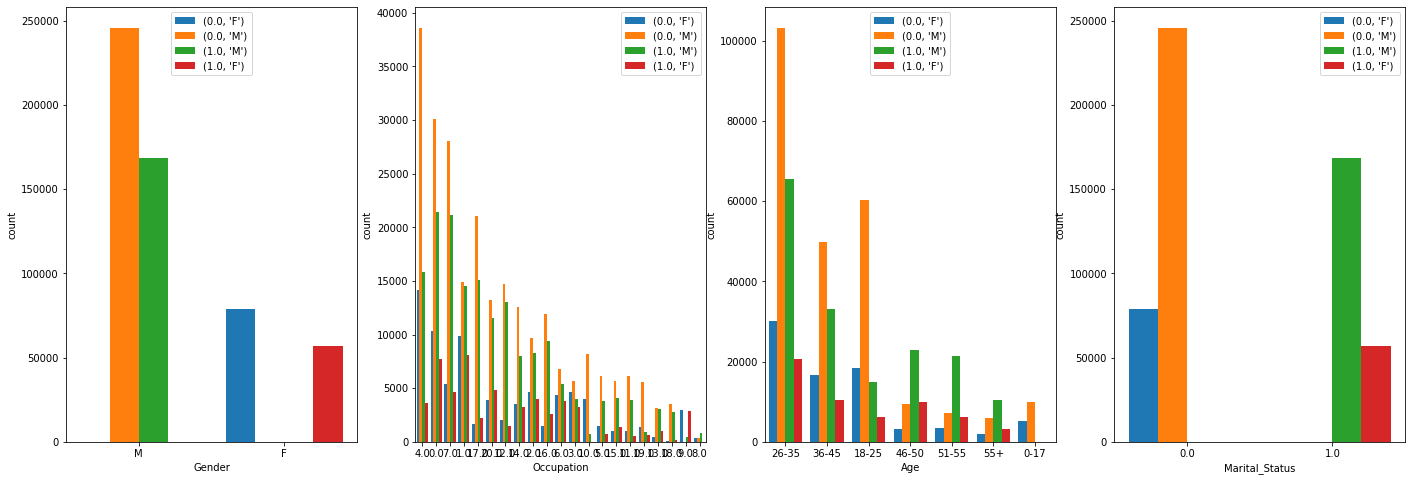

In [31]:
fig, ax =plt.subplots(ncols=4,nrows= 1, sharex=False, figsize=(24,6))
df_train.groupby('Gender').sum()['Purchase']          .plot(kind = 'pie',autopct = '%1.2f',title  ='Gender Vs Payment',ax= ax[0])
df_train.groupby('Occupation').sum()['Purchase']      .plot(kind = 'pie',autopct = '%1.2f',title  ='Occupation Vs Payment',ax= ax[1])
df_train.groupby('Age').sum()['Purchase']             .plot(kind = 'pie',autopct = '%1.2f',title  ='Age Vs Payment',ax= ax[2])
df_train.groupby('Marital_Status').sum()['Purchase']  .plot(kind = 'pie',autopct = '%1.2f',title  ='Marital_Status Vs Payment',ax= ax[3])
plt.show()

fig, ax =plt.subplots(ncols=4,nrows= 1, sharex=False, figsize=(24,8))
Hue=df_train[['Marital_Status', 'Gender']].apply(tuple, axis=1)
sns.countplot(x = 'Gender',        hue =Hue,data = df_train,order = df_train['Gender'].value_counts().index,saturation=1,ax = ax[0])
sns.countplot(x = 'Occupation',    hue =Hue,data = df_train,order = df_train['Occupation'].value_counts().index,saturation=1,ax = ax[1])
sns.countplot(x = 'Age',           hue =Hue,data = df_train,order = df_train['Age'].value_counts().index  ,saturation=1,ax = ax[2])
sns.countplot(x = 'Marital_Status',hue =Hue,data = df_train,order = df_train['Marital_Status'].value_counts().index,saturation=1,ax = ax[3])
plt.show()


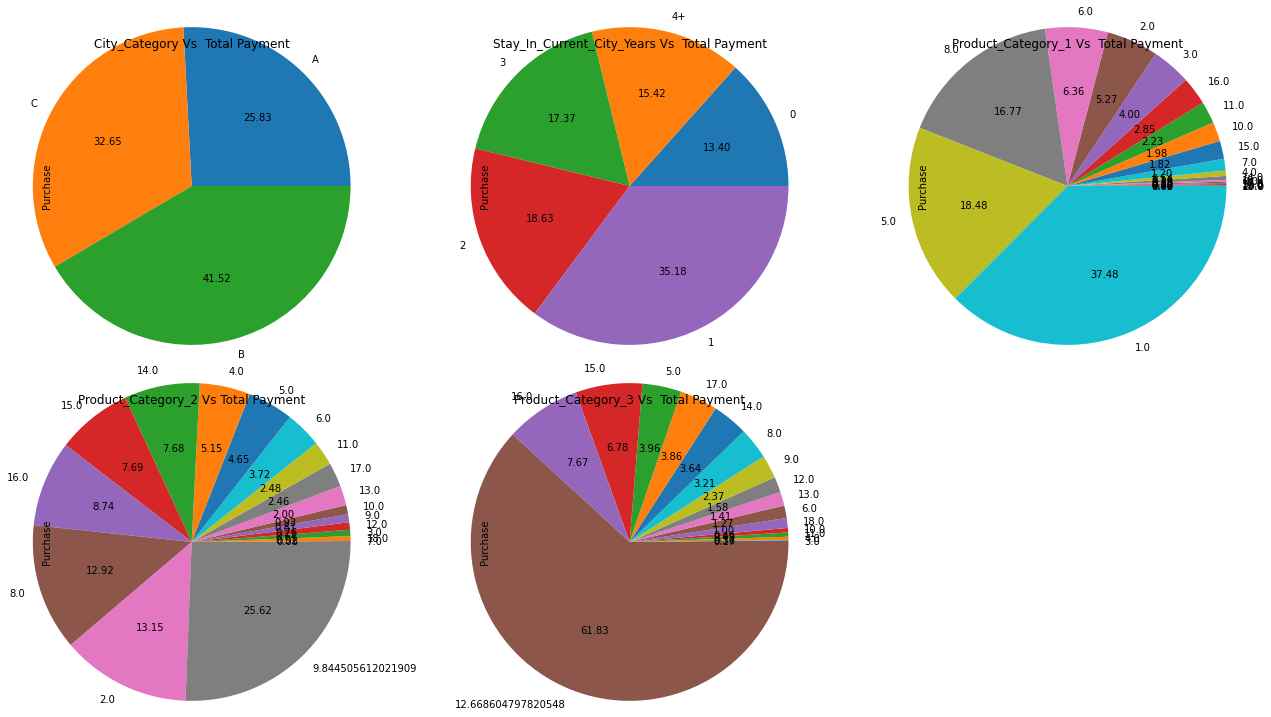

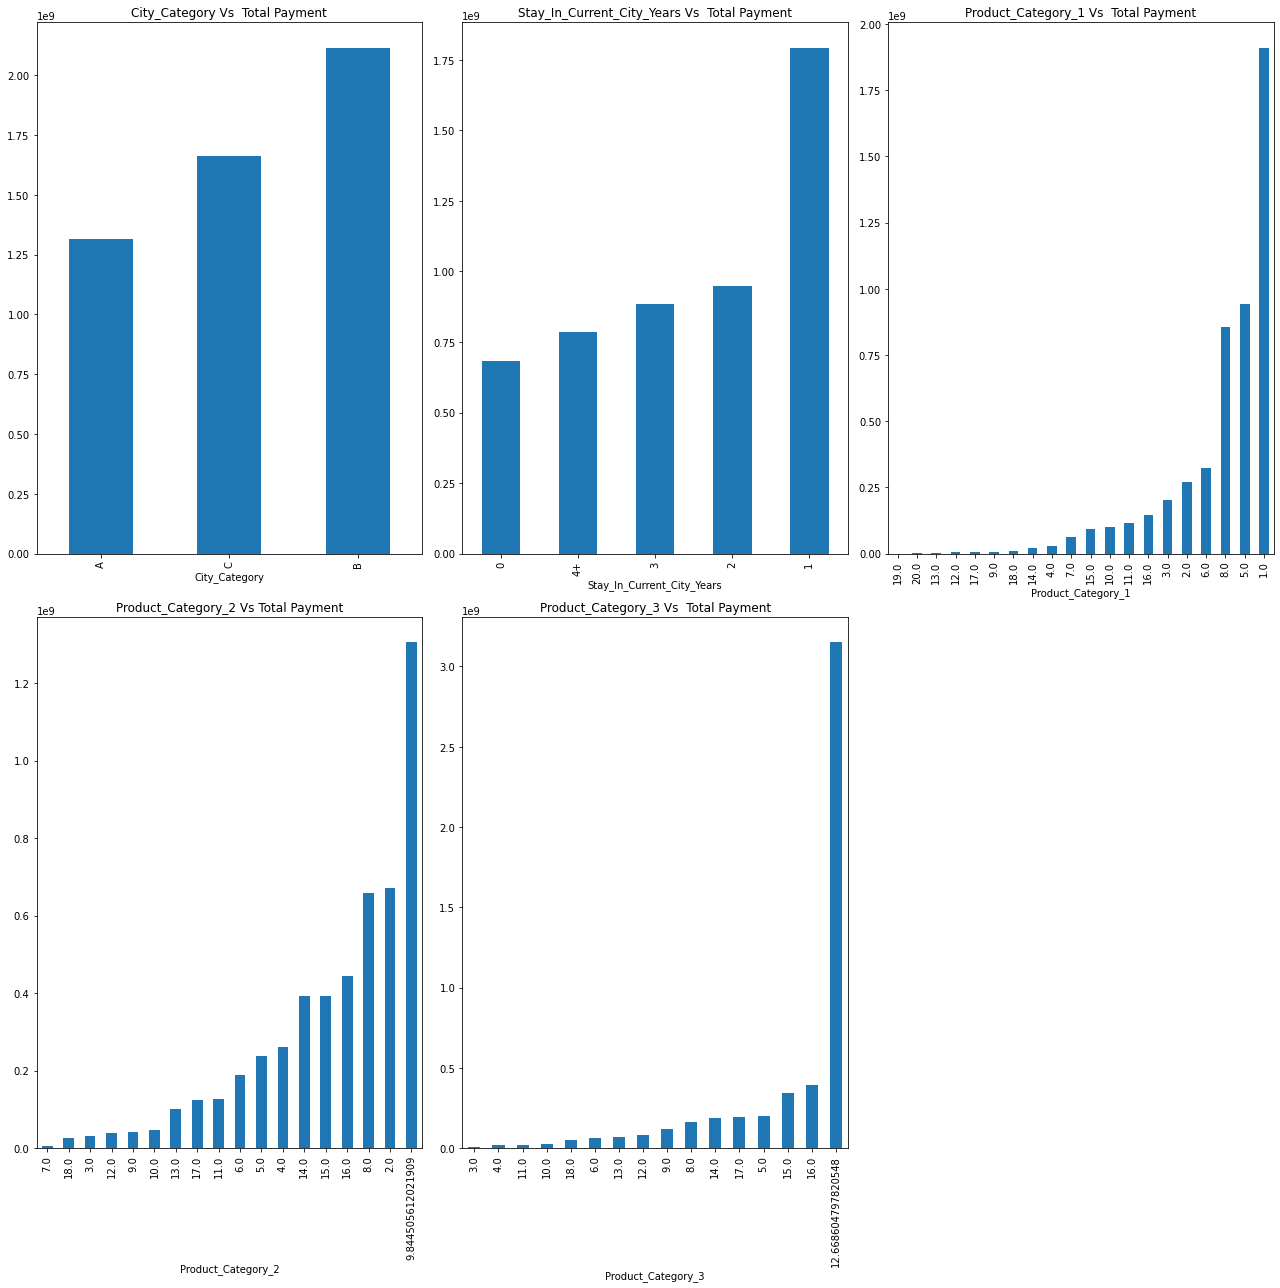

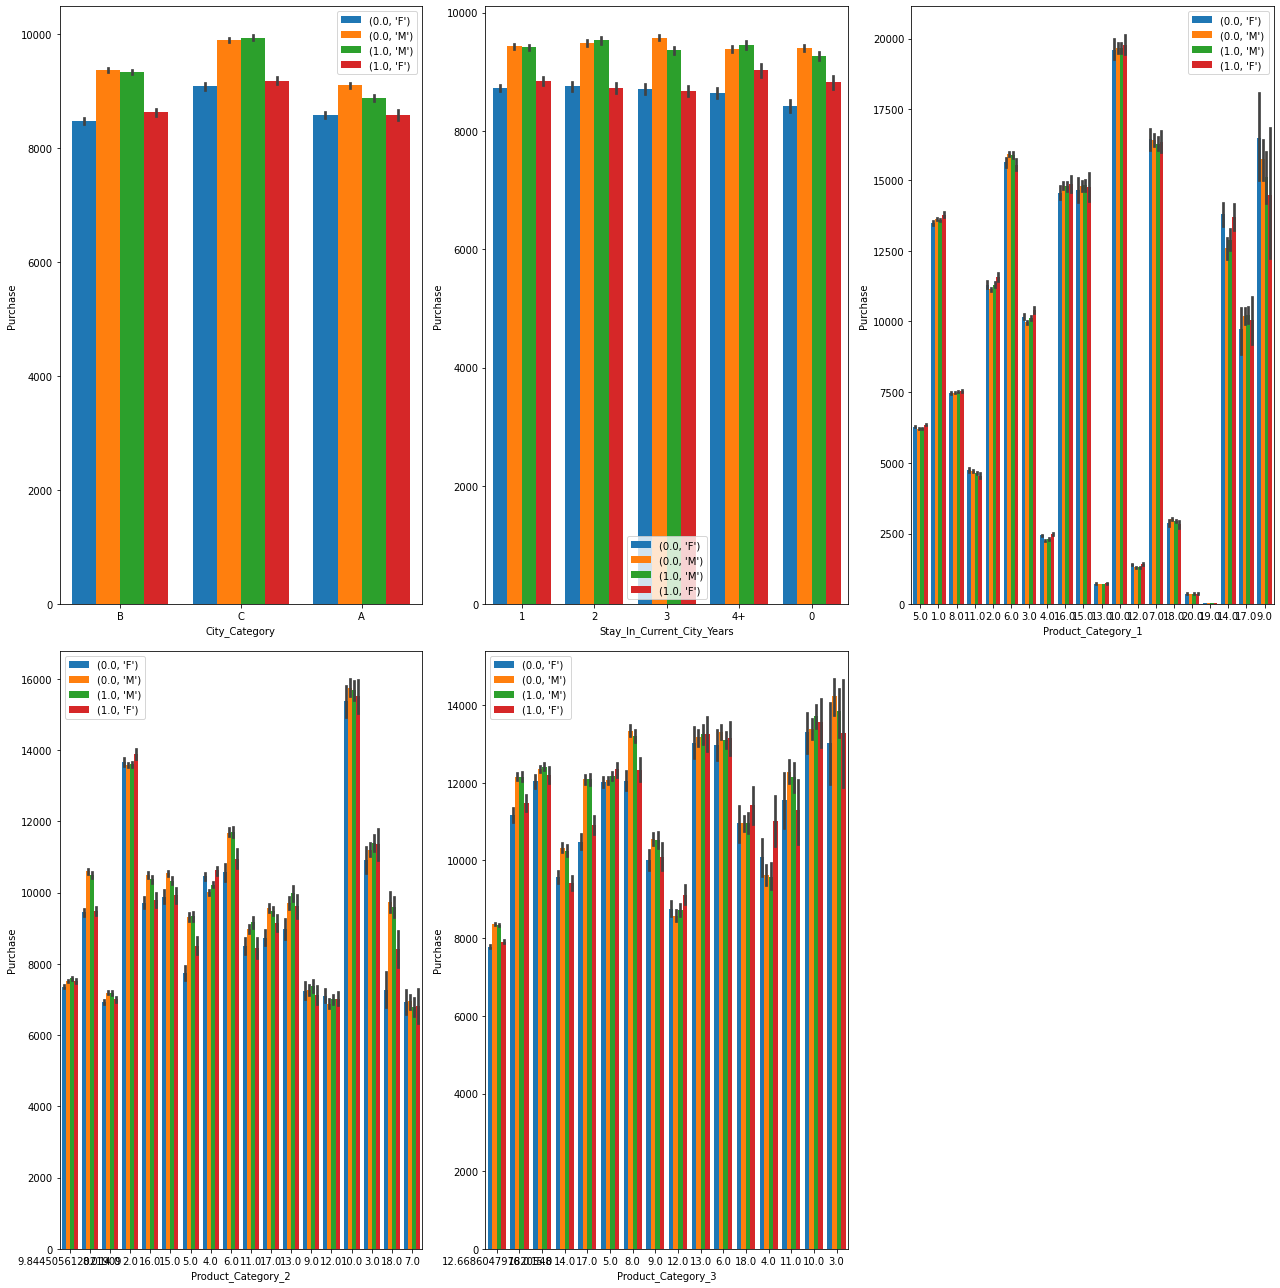

In [32]:
print('\n\n\n')

fig, ax =plt.subplots(ncols=3,nrows= 2, sharex=False, figsize=(18,10))
# df_train.groupby('City_Category').size().sort_values().plot(kind = 'pie',autopct = '%1.2f',title  ='City_Category  ',ax= ax[0, 0])
# df_train.groupby('Stay_In_Current_City_Years').size().sort_values().plot(kind = 'pie',autopct = '%1.2f',title  ='Stay_In_Current_City_Years  ',ax= ax[0, 1])
# df_train.groupby('Product_Category_1').size().sort_values().plot(kind = 'pie',autopct = '%1.2f',title  ='Product_Category_1  ',ax= ax[0, 2])
# df_train.groupby('Product_Category_2').size().sort_values().plot(kind = 'pie',autopct = '%1.2f',title  ='Product_Category_2  ',ax= ax[1, 0])
# df_train.groupby('Product_Category_3').size().sort_values().plot(kind = 'pie',autopct = '%1.2f',title  ='Product_Category_3  ',ax= ax[1, 1])

df_train.groupby('City_Category').sum()['Purchase'].sort_values()          .plot(kind = 'pie',autopct = '%1.2f',title  ='City_Category Vs  Total Payment',ax= ax[0, 0],radius=1.5)
df_train.groupby('Stay_In_Current_City_Years').sum()['Purchase'].sort_values()      .plot(kind = 'pie',autopct = '%1.2f',title  ='Stay_In_Current_City_Years Vs  Total Payment',ax= ax[0, 1],radius=1.5)
df_train.groupby('Product_Category_1').sum()['Purchase'].sort_values()             .plot(kind = 'pie',autopct = '%1.2f',title  ='Product_Category_1 Vs  Total Payment',ax= ax[0, 2],radius=1.5)
df_train.groupby('Product_Category_2').sum()['Purchase'].sort_values()  .plot(kind = 'pie',autopct = '%1.2f',title  ='Product_Category_2 Vs Total Payment',ax= ax[1, 0],radius=1.5)
df_train.groupby('Product_Category_3').sum()['Purchase'].sort_values()  .plot(kind = 'pie',autopct = '%1.2f',title  ='Product_Category_3 Vs  Total Payment',ax= ax[1, 1],radius=1.5)

fig.tight_layout()
fig.delaxes(ax[1][2])
plt.show()

fig, ax =plt.subplots(ncols=3,nrows= 2, sharex=False, figsize=(18,18))
df_train.groupby('City_Category').sum()['Purchase'].sort_values()               .plot(kind = 'bar',title  ='City_Category Vs  Total Payment',ax= ax[0, 0])
df_train.groupby('Stay_In_Current_City_Years').sum()['Purchase'].sort_values()  .plot(kind = 'bar',title  ='Stay_In_Current_City_Years Vs  Total Payment',ax= ax[0, 1])
df_train.groupby('Product_Category_1').sum()['Purchase'].sort_values()          .plot(kind = 'bar',title  ='Product_Category_1 Vs  Total Payment',ax= ax[0, 2])
df_train.groupby('Product_Category_2').sum()['Purchase'].sort_values()          .plot(kind = 'bar',title  ='Product_Category_2 Vs Total Payment',ax= ax[1, 0])
df_train.groupby('Product_Category_3').sum()['Purchase'].sort_values()          .plot(kind = 'bar',title  ='Product_Category_3 Vs  Total Payment',ax= ax[1, 1])
fig.tight_layout()
fig.delaxes(ax[1][2])
plt.show()

fig, ax =plt.subplots(ncols=3,nrows= 2, sharex=False, figsize=(18,18))
Hue=df_train[['Marital_Status', 'Gender']].apply(tuple, axis=1)
sns.barplot(x = 'City_Category',               y = 'Purchase',hue =Hue,data = df_train,order = df_train['City_Category'].value_counts().index,saturation=1,ax = ax[0, 0])
sns.barplot(x = 'Stay_In_Current_City_Years',  y = 'Purchase',hue =Hue,data = df_train,order = df_train['Stay_In_Current_City_Years'].value_counts().index,saturation=1,ax = ax[0, 1])
sns.barplot(x = 'Product_Category_1',          y = 'Purchase',hue =Hue,data = df_train,order = df_train['Product_Category_1'].value_counts().index,saturation=1,ax = ax[0, 2])
sns.barplot(x = 'Product_Category_2',          y = 'Purchase',hue =Hue,data = df_train,order = df_train['Product_Category_2'].value_counts().index,saturation=1,ax = ax[1, 0])
sns.barplot(x = 'Product_Category_3',          y = 'Purchase',hue =Hue,data = df_train,order = df_train['Product_Category_3'].value_counts().index,saturation=1,ax = ax[1, 1])

fig.tight_layout()
fig.delaxes(ax[1][2])
plt.show()

In [33]:
# Total cost payment by Married male & Unmarried male the City Category C is higher than B and then A 
# Unmarreid male who living upto 3 year 

In [34]:
# # fig, ax =plt.subplots(ncols=1,nrows= 5, sharex=False, figsize=(18,10))
# fig, ax =plt.subplots( sharex=False, figsize=(18,10))

# Hue=df_train[['Marital_Status', 'Gender','City_Category']].apply(tuple, axis=1)
# sns.barplot(x = 'Age',               y = 'Purchase',hue =Hue,data = df_train,order = df_train['Age'].value_counts().index,saturation=1)#,ax = ax[0, 0])
# plt.show()

# fig, ax =plt.subplots( sharex=False, figsize=(18,10))
# Hue=df_train[['Marital_Status', 'Gender','Stay_In_Current_City_Years']].apply(tuple, axis=1)
# sns.barplot(x = 'Age',  y = 'Purchase',hue =Hue,data = df_train,order = df_train['Age'].value_counts().index,saturation=1)#,ax = ax[1, 0])
# plt.show()

# fig, ax =plt.subplots( sharex=False, figsize=(18,10))
# Hue=df_train[['Marital_Status', 'Gender','Age']].apply(tuple, axis=1)
# sns.barplot(x = 'Product_Category_1',          y = 'Purchase',hue =Hue,data = df_train,order = df_train['Product_Category_1'].value_counts().index,saturation=1)#,ax = ax[2, 0])
# plt.show()

# fig, ax =plt.subplots( sharex=False, figsize=(18,10))
# Hue=df_train[['Marital_Status', 'Gender','Age']].apply(tuple, axis=1)
# sns.barplot(x = 'Product_Category_2',          y = 'Purchase',hue =Hue,data = df_train,order = df_train['Product_Category_2'].value_counts().index,saturation=1)#,ax = ax[3, 0])
# plt.show()

# fig, ax =plt.subplots( sharex=False, figsize=(18,10))
# Hue=df_train[['Marital_Status', 'Gender','Age']].apply(tuple, axis=1)
# sns.barplot(x = 'Product_Category_3',          y = 'Purchase',hue =Hue,data = df_train,order = df_train['Product_Category_3'].value_counts().index,saturation=1)#,ax = ax[4, 0])
# fig.tight_layout()
# plt.show()

# Satastical parameter abd corelations

In [35]:
df_train.corr()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,1.000000,-0.023971,0.020443,0.003825,0.001266,0.001888,0.004716
Occupation,-0.023971,1.000000,0.024280,-0.007618,-0.000319,0.007264,0.020833
Marital_Status,0.020443,0.024280,1.000000,0.019888,0.012510,0.010696,-0.000463
Product_Category_1,0.003825,-0.007618,0.019888,1.000000,0.373790,0.082743,-0.343703
Product_Category_2,0.001266,-0.000319,0.012510,0.373790,1.000000,0.320229,-0.179365
Product_Category_3,0.001888,0.007264,0.010696,0.082743,0.320229,1.000000,-0.012284
Purchase,0.004716,0.020833,-0.000463,-0.343703,-0.179365,-0.012284,1.000000


###  Corelation matrix before label encoding

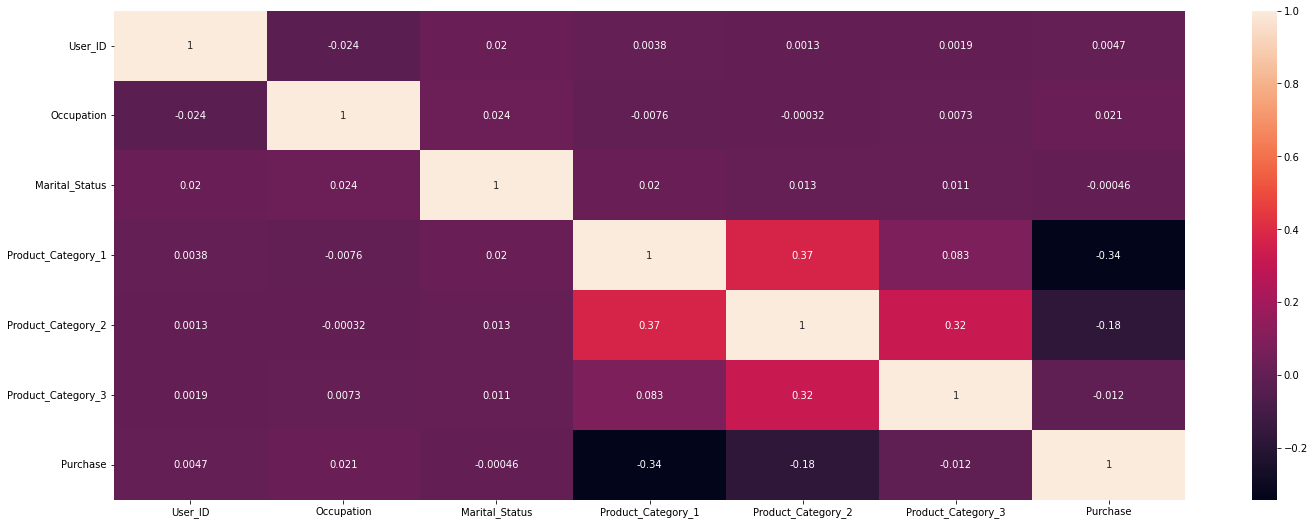

In [36]:
plt.figure(figsize =(24,9) )
sns.heatmap(df_train.corr(),annot = True)
plt.show()

### Observation 
1. there is few Column are directly & inversly proportion , consideration of only
1. Occupation  ----> 0.021,
1. Product_Category_1  ----> -0.34, 
1. Product_Category_2  ----> -0.18,
1. Product_Category_3  ----> -0.012

In [37]:
clm = df_train.select_dtypes(include = ['object']).keys()            # OneHot encoder only object datatype not numerical

In [38]:
from sklearn.preprocessing import OneHotEncoder
lt =[]
for i in clm :
    df0 = pd.DataFrame(df_train[i])
    df_temp = pd.DataFrame(OneHotEncoder().fit_transform(df0).toarray())
    df_temp.columns = list(df_train[i].unique())
    lt.append(df_temp)

In [39]:
df_obj = pd.concat(lt,axis = 1)
df_obj.head(3)

,F,M,0-17,55+,26-35,46-50,51-55,36-45,18-25,A,C,B,2,4+,3,1,0
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [40]:
print( 'Shape of the Encoded file : '  ,df_obj.shape)

Shape of the Encoded file :  (550068, 17)


In [41]:
df_int = df_train.select_dtypes(include = ['int64','float64']) # selecting the integer data file to merge into dataframe

In [42]:
df_final = pd.concat([df_int,df_obj],axis = 1)                      # Merge

In [43]:
df_final.head(2)

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,F,M,0-17,...,36-45,18-25,A,C,B,2,4+,3,1,0
0,1000001.0,10.0,0.0,3.0,9.844506,12.668605,8370,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1000001.0,10.0,0.0,1.0,6.000000,14.000000,15200,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Corelation matrix after label encoding

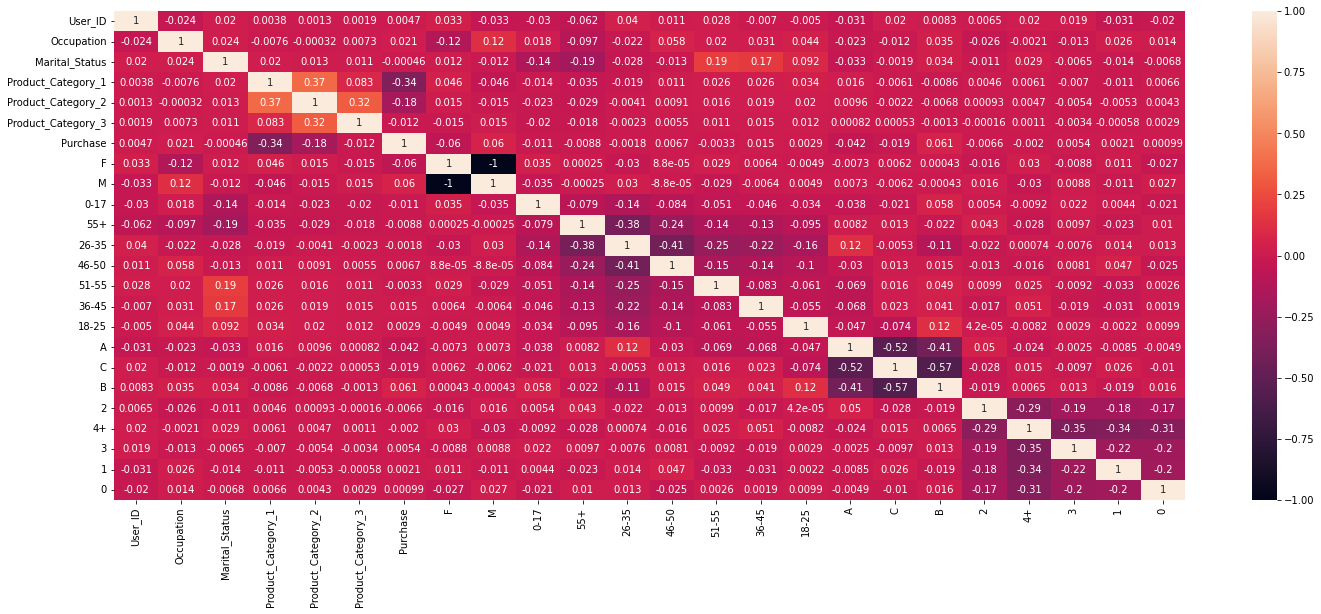

In [44]:
plt.figure(figsize =(24,9) )
sns.heatmap(df_final.corr(),annot = True)
plt.show()

In [45]:
df_final.keys()

Index(['User_ID', 'Occupation', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase', 'F', 'M',
       '0-17', '55+', '26-35', '46-50', '51-55', '36-45', '18-25', 'A', 'C',
       'B', '2', '4+', '3', '1', '0'],
      dtype='object')

### Selecting those column have highly corelated 

In [46]:
df_final = df_final[['Product_Category_1','Product_Category_2','Product_Category_3','M','F','46-50','Purchase']]

In [47]:
df_final.skew()                                               # Checking the symmetricity of dataset

Product_Category_1    1.025735
Product_Category_2   -0.197236
Product_Category_3   -1.390268
M                    -1.173946
F                     1.173946
46-50                 1.500013
Purchase              0.600140
dtype: float64

### Observation
1. Product_Category_1  - Positive skew ness of dataframe
1. Product_Category_3  - Highly negetive skewness 
1. M                   - Higly negetive skewness
1. F                   - Positive skewness
1. 46-50               - higly Postive skew ness

In [48]:
df_No_out = quntile(df_final)                       # Skewness minimizes                              
df_No_out.skew()

Product_Category_1    0.795984
Product_Category_2   -0.013418
Product_Category_3    0.000000
M                     0.000000
F                     0.000000
46-50                 0.000000
Purchase              0.909962
dtype: float64

In [49]:
Y = df_final['Purchase']
X = df_final.drop(columns='Purchase',axis =1)

In [50]:
print( 'shape of Target Dataset ' ,Y.shape )
print( 'shape of feature Dataset ' ,X.shape )

shape of Target Dataset  (550068,)
shape of feature Dataset  (550068, 6)


### Train test split

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X_train,X_test ,Y_train,Y_test = train_test_split(X,Y,test_size= 0.15 ,random_state=42)

In [53]:
print(' Shape of the X_train  :  ',X_train.shape)
print(' Shape of the X_test   :  ',X_test .shape)
print(' Shape of the Y_train  :  ',Y_train.shape)
print(' Shape of the Y_test   :  ',Y_test .shape)

 Shape of the X_train  :   (467557, 6)
 Shape of the X_test   :   (82511, 6)
 Shape of the Y_train  :   (467557,)
 Shape of the Y_test   :   (82511,)


### Model function 

In [54]:
def linerReg(X_test,Y_test,X_train,Y_train):
    reg = Ridge()
    para_grid = {'alpha' : [500,1000]}
    reg_Cv = GridSearchCV(reg , para_grid ,scoring  = 'neg_median_absolute_error',cv = 10)
    reg_Cv.fit(X_train,Y_train,sample_weight=0.2)
    Y_pred = reg_Cv.predict(X_test)
#     print(reg_Cv.best_params_)
    return Y_pred

In [55]:
def Ran_For_Regress(X_test,Y_test,X_train,Y_train):
    model = RandomForestRegressor()
    model.fit(X_train,Y_train )
    prediced_data = model.predict(X_test)
#     print('R2_score accuracy level : ',r2_score(Y_test,prediced_data))
    return prediced_data

In [56]:
def XGB_model(X_test,Y_test,X_train,Y_train):
    xgbr = xgb.XGBRegressor(verbosity=0) 
    xgbr.fit(X_train, Y_train)
    Y_pred_XG = xgbr.predict(X_test)
    score = xgbr.score(X_train, Y_train)  
    
    print("Training score: ", score)
    print('Accuracy Score using XGBoost regression model : ',r2_score(Y_test,Y_pred_XG))
    return Y_pred_XG

# Training score:  0.6976257209599621
# Accuracy Score using XGBoost regression model :  0.6825853377873394

### Refrence accuracy - 

https://www.kaggle.com/code/shashanksadafule/black-friday-sales-excellent-eda-and-prediction     [r2_score = 0.6537 | XGboost


### Ridge linear Regression model 

In [57]:
Y_pred_LR = linerReg(X_test,Y_test,X_train,Y_train)
print('Accuracy Score using liner regression model : ',r2_score(Y_test,Y_pred_LR))
# Accuracy Score using liner regression model :  0.1286371306139532

Accuracy Score using liner regression model :  0.12235497226308656


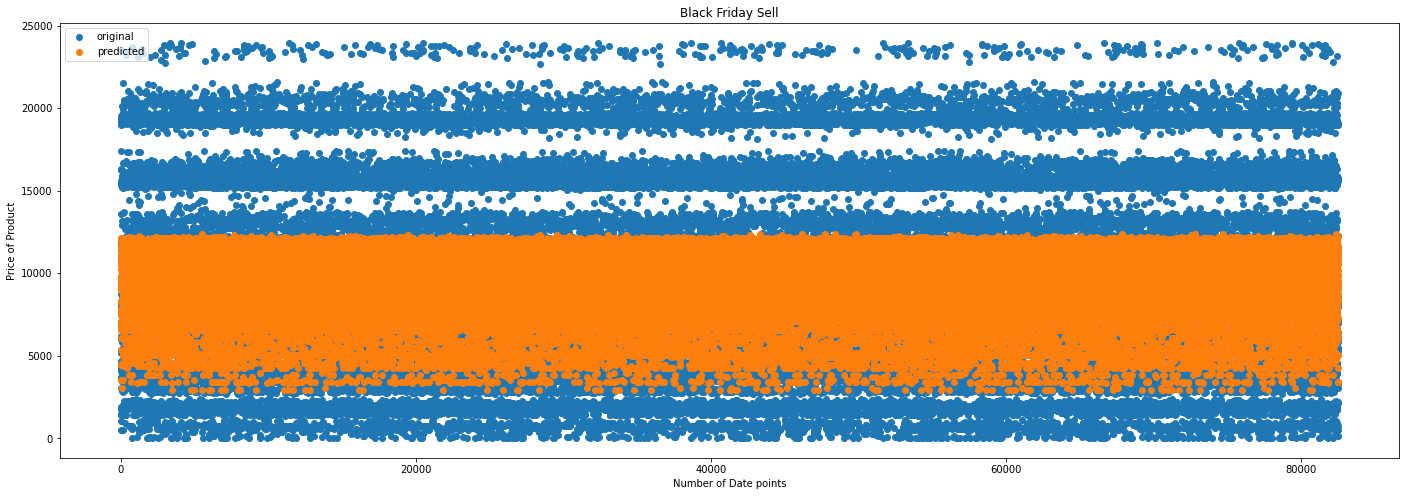

In [58]:
model_plot(Y_test,Y_pred_LR) 

In [59]:
## XGB Model

In [60]:
Y_pred_XGB = XGB_model(X_test,Y_test,X_train,Y_train)

Training score:  0.6604683511211373
Accuracy Score using XGBoost regression model :  0.65240358380584


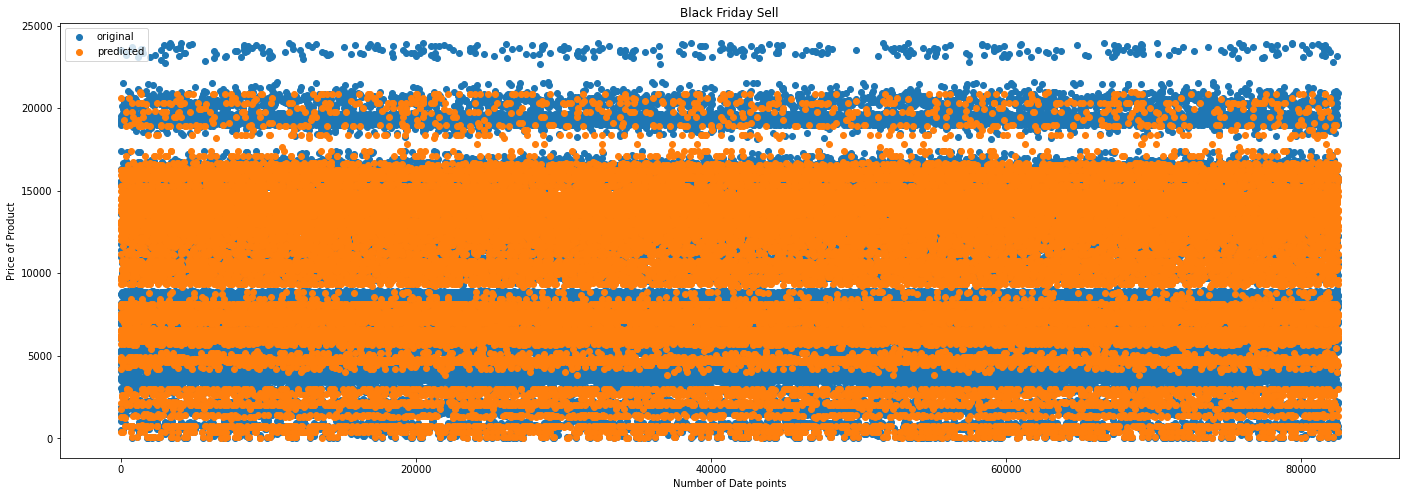

In [61]:
model_plot(Y_test,Y_pred_XGB) 

In [62]:
### Random Forest regresson model 

In [63]:
Y_pred_RFR = Ran_For_Regress(X_test,Y_test,X_train,Y_train)

In [64]:
r2_score(Y_test,Y_pred_RFR)

0.6523464521498024

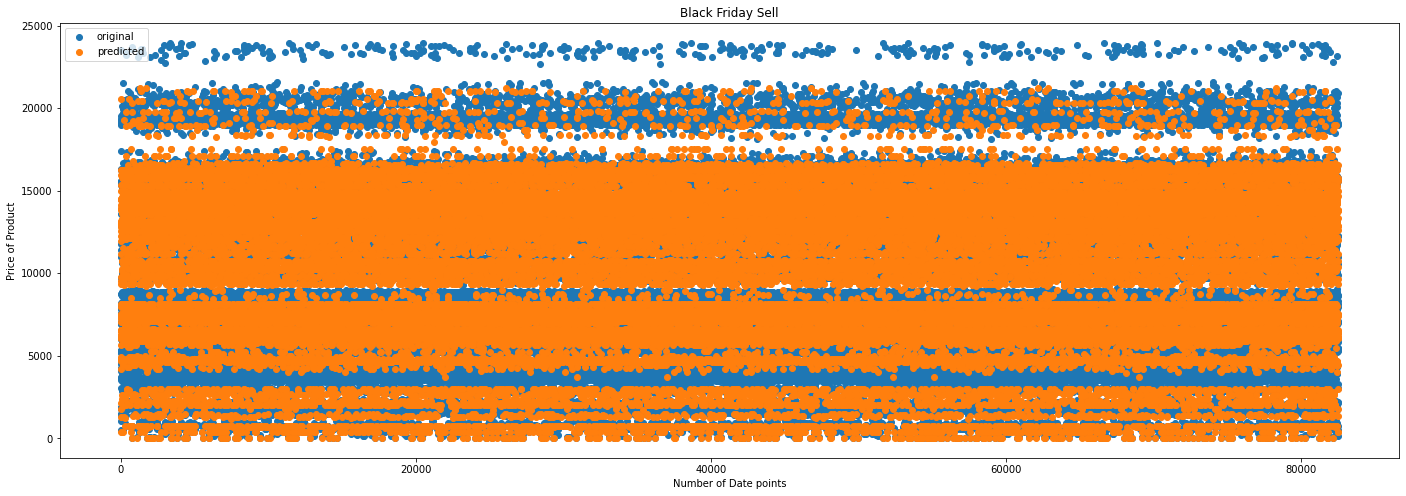

In [65]:
model_plot(Y_test,Y_pred_RFR) 

In [66]:
# df_main.keys()
# tes = df_main.iloc[len(Y):,:]
# clm_obj = tes.select_dtypes(include = 'object').keys()
# from sklearn.preprocessing import OneHotEncoder
# lt =[]
# for i in clm_obj :
#     df0 = pd.DataFrame(tes[i])
#     df_temp = pd.DataFrame(OneHotEncoder().fit_transform(df0).toarray())
#     df_temp.columns = list(df_train[i].unique())
#     lt.append(df_temp)
# df_obj_test = pd.concat(lt,axis = 1)
# df_obj_test.head(3)

# df_int_test = tes.select_dtypes(include = ['int64','float64'])
# test_final = pd.concat([df_int_test,df_obj_test],axis = 1)

# test_new =test_final[['Product_Category_1','Product_Category_2','Product_Category_3','M','F','46-50']]
# test_new.head()
# xgbr = xgb.XGBRegressor(verbosity=0) 
# xgbr.fit(X_train, Y_train)
# Y_pred_XG_tes = xgbr.predict(test_new)